## Overview of the Project

This data collection contains simulated data from the Starbucks rewards mobile app, which replicates user behaviour. Starbucks sends out an offer to its mobile app users every few days. An offer might be as simple as a drink commercial or as complex as a discount or a BOGO deal (buy one get one free). During certain weeks, certain users may not receive any offers.

This data set presents a challenge in that not all users receive the same offer.

There are three files in this data set. The first file contains information about each offer, such as its duration and the amount of money required to finish it (difficulty). The second file contains information on the customer's demographics.

## Problem Statement and its Metrics

I selected to solve the problem of developing a model that predicts whether a customer will respond to an offer. There are two steps to my solution to this problem. First, I'll combine the client profile, offer portfolio, and transaction data. The qualities of an offer, consumer demographic data, and whether the offer was successful will be described in each row of this integrated dataset. Second, I'll evaluate the precision and F1-score of a naive model that assumes all offers are accepted. This gives me a starting point for analysing the performance of the models I build. The accuracy of a model is determined by how well it predicts whether or not an offer will be accepted.

However, accuracy is not a good measure of model performance if the fraction of successful or unsuccessful offers is relatively low. In this case, assessing a model's precision and recall provides more information about its performance. Because it is "a weighted average of the precision and recall measurements," I chose the F1-score metric.

In [1]:
import math
import progressbar
import seaborn as sns
import json
import numpy as np
import pandas as pd
import re

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

%matplotlib inline

### Import Data

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### 1. Portfolio Data

#### Dataset column description :

**portfolio.json**

- reward (int) - reward given for completing an offer
- channels (list of strings)
- difficulty (int) - minimum required spend to complete an offer
- duration (int) - time for offer to be open, in days
- offer_type (string) - type of offer ie BOGO, discount, informational
- id (string) - offer id


In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


### Cleaning Portfolio Data:

Instructions:
1. rename id col name to offer_id
2. one-hot encode offer_type column
3. one-hot encode channels

In [5]:
# 1. rename id col name to offer_id.
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [6]:
# 2. one-hot encode offer_type column

for index, row in portfolio.iterrows():
    for offertype in ['bogo', 'informational', 'discount']:
        if offertype in portfolio.loc[index, 'offer_type']:
            portfolio.loc[index, offertype] = 1
        else:
            portfolio.loc[index, offertype] = 0
portfolio.drop(columns='offer_type', inplace=True)

In [7]:
# 3. one-hot encode channels

for index, row in portfolio.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in portfolio.loc[index, 'channels']:
            portfolio.loc[index, channel] = 1
        else:
            portfolio.loc[index, channel] = 0
portfolio.drop(columns='channels', inplace=True)

In [8]:
portfolio.head()

,reward,difficulty,duration,offer_id,bogo,informational,discount,web,email,social,mobile
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1.0,0.0,0.0,0.0,1.0,1.0,1.0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0.0,1.0,0.0,1.0,1.0,0.0,1.0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,0.0,0.0,1.0,1.0,0.0,1.0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,1.0,1.0,1.0,0.0,0.0


### 2. Profile Data

#### Dataset column description :

**profile.json**

- gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- age (int) - age of the customer
- id (str) - customer id
- became_member_on (int) - date when customer created an app account
- income (float) - customer's income

In [9]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


### Cleaning Profile Data
Instruction:
1. rename id col name to customer_id.
2. change age value 118 to nan.
3. create readable date format in became_member_on column.
4. drop rows with no gender, income, age data
5. convert gender values to numeric 0s and 1s
6. add start year and start month columns (for further analysis)

In [11]:
# 1. rename id col name customer_id.
profile.rename(columns={'id': 'customer_id'}, inplace=True)

In [12]:
# 2. change age value 118 to nan.
print(profile.where(profile.age==118).count())
profile.age.replace(118, np.nan, inplace=True)

gender                 0
age                 2175
customer_id         2175
became_member_on    2175
income                 0
dtype: int64


In [13]:
# 3. create readable date format for became_member_on column.
print(len(profile[profile['gender'].isnull()].index))
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

2175


In [14]:
# 4. drop rows with no gender, income, age data
profile = profile.drop(profile[profile['gender'].isnull()].index)

In [15]:
# 5. Convert gender values to numeric 0s and 1s
profile['gender'] = profile['gender'].apply(lambda x: 1 if x == 'M' else 0)

In [16]:
# 6. add start_year column
profile['start_year'] = profile.became_member_on.dt.year
profile["start_month"] = profile.became_member_on.dt.month

In [17]:
profile.head()

,gender,age,customer_id,became_member_on,income,start_year,start_month
1,0,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7
3,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5
5,1,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4
8,1,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2
12,1,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11


### 3. Transcript Data
#### Dataset column description :

**transcript.json**

- person (str) - customer id
- event (str) - record description (ie transaction, offer received, offer viewed, etc.)
- value - (dict of strings) - either an offer id or transaction amount depending on the record
- time (int) - time in hours since start of test. The data begins at time t=0

In [18]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [19]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


### Cleaning Transcript Data
Instruction:
1. rename person col name to customer_id.
2. create separate columns for amount and offer_id from value col.
3. drop transaction rows whose customer_id is not in profile:customer_id
4. convert time in hours to time in days
5. segregate offer and transaction data 
6. finally drop duplicates if any

In [20]:
# 1. rename person col name to customer_id.
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [21]:
# 2. create separate columns for amount and offer_id from value col.

def create_amount_col(val):
    if list(val.keys())[0] in ['amount']:
        return list(val.values())[0]

def create_offer_id_col(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]
      
transcript['amount'] = transcript.value.apply(create_amount_col)
transcript['offer_id'] = transcript.value.apply(create_offer_id_col)

# drop value column
transcript.drop(columns=['value'], inplace=True)

# change amount column type to float
transcript.amount.astype('float')

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
306529    1.59
306530    9.53
306531    3.61
306532    3.53
306533    4.05
Name: amount, Length: 306534, dtype: float64

In [22]:
# 3. drop transaction rows whose customer_id is not in profile:customer_id
transcript = transcript[transcript.customer_id.isin(profile.customer_id)]

# 4. convert time in hours to time in days
transcript['time'] /= 24.0

# drop the duplicated value, and reset the index
transcript.drop_duplicates(inplace=True)

transcript.reset_index(drop=True, inplace=True)

In [23]:
# 5. segregate offer and transaction data 

transaction_df = transcript[transcript.event=='transaction'].copy()
transaction_df.drop(columns=['offer_id', 'event'], inplace=True)

In [24]:
# 6. seggregate offer and transaction data 

# extract offer-related from transcript data
offers_df = transcript[transcript.event!='transaction'].copy()

# one-hot encode offer event
offers_df['received'] = offers_df.event.apply(lambda x: 1 if x == 'offer received' else 0)
offers_df['completed'] = offers_df.event.apply(lambda x: 1 if x == 'offer completed' else 0)
offers_df['viewed'] = offers_df.event.apply(lambda x: 1 if x == 'offer viewed' else 0)

offers_df.drop(columns=['event', 'amount'], inplace=True)

## Exploratory Data Analysis

#### Check for any missing values in each column

In [25]:
profile.isnull().sum()

gender              0
age                 0
customer_id         0
became_member_on    0
income              0
start_year          0
start_month         0
dtype: int64

#### Statistics of customer age and income attributes for specified income

In [26]:
profile[profile['income'].notnull()].describe()

,gender,age,income,start_year,start_month
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,0.572277,54.393524,65404.991568,2016.620169,6.695582
std,0.494765,17.383705,21598.299410,1.198245,3.488853
min,0.000000,18.000000,30000.000000,2013.000000,1.000000
25%,0.000000,42.000000,49000.000000,2016.000000,4.000000
50%,1.000000,55.000000,64000.000000,2017.000000,7.000000
75%,1.000000,66.000000,80000.000000,2017.000000,10.000000
max,1.000000,101.000000,120000.000000,2018.000000,12.000000


#### Computing gender distribution in profile data

In [27]:
profile.gender.value_counts()

1    8484
0    6341
Name: gender, dtype: int64

#### Computing the percent of customers vs which year enrolled as a member in the database

In [28]:
year_count = profile['start_year'].value_counts()

year_count *= 100 / year_count.sum()
year_count

2017    37.767285
2018    24.748735
2016    20.397976
2015    10.772344
2014     4.465430
2013     1.848229
Name: start_year, dtype: float64

#### Compute what percent of customers vs which month enrolled as a member

In [29]:
month_count = profile['became_member_on'].apply(lambda date: date.month).value_counts()

month_count *= 100 / year_count.sum()
month_count.sort_index()

1     1327.0
2     1042.0
3     1145.0
4     1145.0
5     1152.0
6     1105.0
7     1189.0
8     1395.0
9     1299.0
10    1386.0
11    1268.0
12    1372.0
Name: became_member_on, dtype: float64

#### Age, Income and  Members General Distribution

Text(0.5, 1.0, 'Membership distribution with joining year')

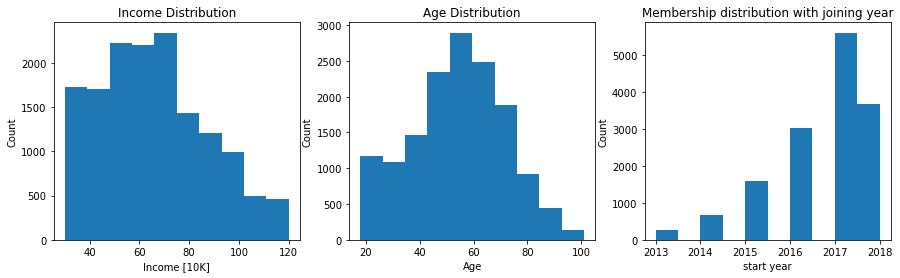

In [30]:
# to be able to draw three subplots in a row
fig, ax = plt.subplots(figsize=(15, 4), nrows=1, ncols=3)

# plot a income distribution in data
plt.sca(ax[0])
plt.hist(profile['income'] * 1E-3 )
plt.xlabel('Income [10K]')
plt.ylabel('Count')
plt.title('Income Distribution')

# plot a age distribution in data
plt.sca(ax[1])
plt.hist(profile['age'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')

# plot a start_year distribution
plt.sca(ax[2])
plt.hist(profile['start_year'])
plt.xlabel('start year')
plt.ylabel('Count')
plt.title('Membership distribution with joining year')

The age distribution plot shows that the median age of a customer is 60, and the majority of our consumers are between the ages of 40 and 70. The number of customers with an average salary of less than 75K is higher than the number of customers with an average salary of $75,000, which is the median of the income distribution. The findings of membership distribution are intriguing: since 2013, 2017 has seen the highest number of registered clients. Except for 2017, the plot also indicates a rising trend in the number of registrations.

#### Income distribution: : Male vs Female

C:\Users\dhand\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\dhand\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


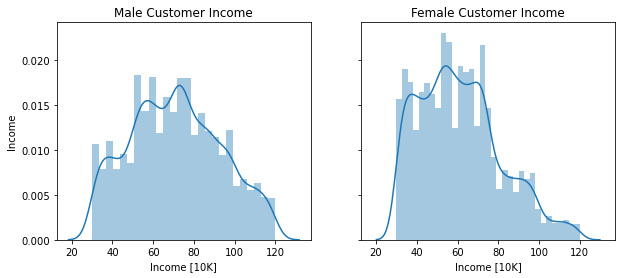

In [31]:
# extract male and female customers
male_customers = profile[profile['gender'] == 0]
female_customers = profile[profile['gender'] == 1]

# to be able to draw two subplots in a row
fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2, sharex=True, sharey=True)

# plot a male customers income distribution
plt.sca(ax[0])
sns.distplot(male_customers['income'] * 1E-3)
plt.xlabel('Income [10K]')
plt.ylabel('Income')
plt.title('Male Customer Income')

# plot a female customers income distribution
plt.sca(ax[1])
sns.distplot(female_customers['income'] * 1E-3)
plt.xlabel('Income [10K]')
plt.ylabel('Income')
plt.title('Female Customer Income');

The graphs show that male and female consumers have similar minimum and maximum incomes, but that the number of male customers in the low-income category is slightly higher than that of female customers.

#### Age distribution: Male vs Female

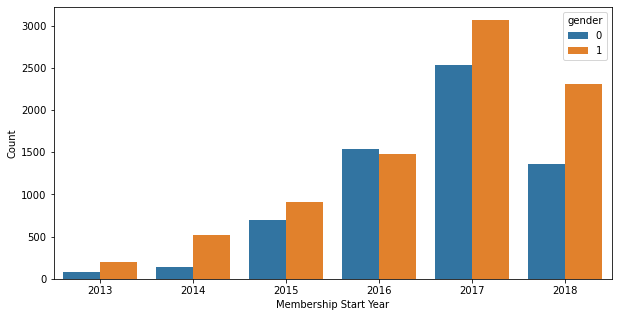

In [32]:
# groupby start_year and gender to plot a graph
membership_date_ = profile.groupby(['start_year', 'gender']).size()
membership_date_ = membership_date_.reset_index()
membership_date_.columns = ['start_year', 'gender', 'count']

# plot a bar graph for age distribution as a function of gender in membership program
plt.figure(figsize=(10, 5))
sns.barplot(x='start_year', y='count', hue='gender', data=membership_date_)
plt.xlabel('Membership Start Year')
plt.ylabel('Count');

The results suggest that most customers joined the Starbucks rewards program in 2017 followed by 2018. Plots also depict that there are more male customers joining the program every year.

#### offer_ids were having the highest counts

In [33]:
offer_id_ = offers_df['offer_id'].unique()
offer_dict = pd.Series(offer_id_).to_dict()
offer_dict = dict([(value, key) for key, value in offer_dict.items()]) 
offers_df['offer_id_'] = offers_df['offer_id'].map(offer_dict)
offers_df['offer_id_'] = offers_df['offer_id'].replace(1, np.nan)
offers_df.head()

,customer_id,time,offer_id,received,completed,viewed,offer_id_
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,1,0,0,2906b810c7d4411798c6938adc9daaa5
2,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d
3,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,1,0,0,3f207df678b143eea3cee63160fa8bed
4,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [34]:
offer_received = offers_df[offers_df['received'] == 1].offer_id_.value_counts()
offer_viewed = offers_df[offers_df['viewed'] == 1].offer_id_.value_counts()
offer_completed = offers_df[offers_df['completed'] == 1].offer_id_.value_counts()

print(offer_received, offer_viewed, offer_completed)

0b1e1539f2cc45b7b9fa7c272da2e1d7    6726
9b98b8c7a33c4b65b9aebfe6a799e6d9    6685
ae264e3637204a6fb9bb56bc8210ddfd    6683
3f207df678b143eea3cee63160fa8bed    6657
2298d6c36e964ae4a3e7e9706d1fb8c2    6655
fafdcd668e3743c1bb461111dcafc2a4    6652
5a8bc65990b245e5a138643cd4eb9837    6643
2906b810c7d4411798c6938adc9daaa5    6631
4d5c57ea9a6940dd891ad53e9dbe8da0    6593
f19421c1d4aa40978ebb69ca19b0e20d    6576
Name: offer_id_, dtype: int64 fafdcd668e3743c1bb461111dcafc2a4    6407
2298d6c36e964ae4a3e7e9706d1fb8c2    6379
4d5c57ea9a6940dd891ad53e9dbe8da0    6329
f19421c1d4aa40978ebb69ca19b0e20d    6310
ae264e3637204a6fb9bb56bc8210ddfd    5901
5a8bc65990b245e5a138643cd4eb9837    5873
9b98b8c7a33c4b65b9aebfe6a799e6d9    3499
3f207df678b143eea3cee63160fa8bed    3487
2906b810c7d4411798c6938adc9daaa5    3460
0b1e1539f2cc45b7b9fa7c272da2e1d7    2215
Name: offer_id_, dtype: int64 fafdcd668e3743c1bb461111dcafc2a4    4957
2298d6c36e964ae4a3e7e9706d1fb8c2    4847
9b98b8c7a33c4b65b9aebfe6a799e6d9    41

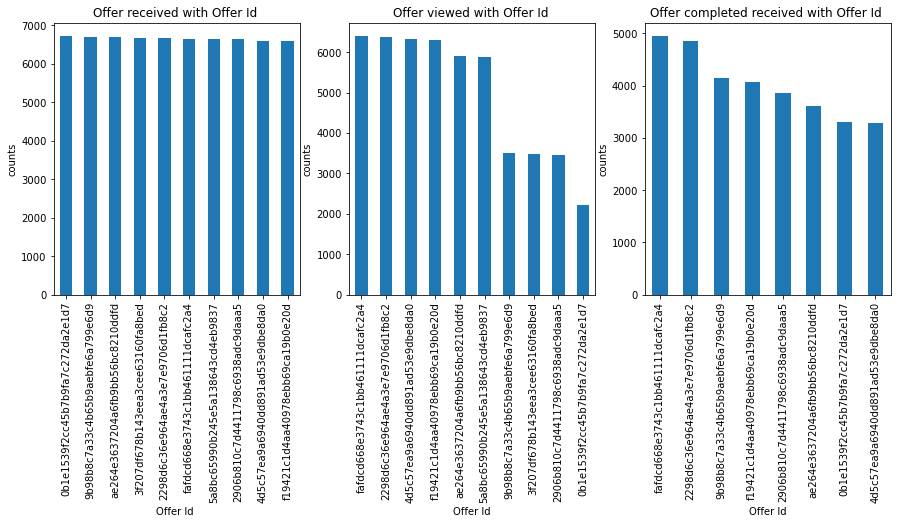

In [35]:
plt.subplot(131)
offer_received = offers_df[offers_df['received'] == 1].offer_id_.value_counts()
offer_received.plot(kind='bar', figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id ')
plt.title('Offer received with Offer Id ');

plt.subplot(132)
offer_viewed = offers_df[offers_df['viewed'] == 1].offer_id_.value_counts()
offer_viewed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id')
plt.title('Offer viewed with Offer Id ');

plt.subplot(133)
offer_completed = offers_df[offers_df['completed'] == 1].offer_id_.value_counts()
offer_completed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id')
plt.title('Offer completed received with Offer Id ');

#### Computing the event distribution

In [36]:
event_counts_ = transcript['event'].value_counts()
total_transactions_ = event_counts_.sum()

transactions_perc = 100 * event_counts_[0] / total_transactions_
offers_perc = 100 * event_counts_[1:].sum() / total_transactions_

print(transactions_perc, offers_perc)

45.507511344112075 54.492488655887925


### Combine offer, customer and transactions data

In [37]:
def combine_data(profile, portfolio, offers_df, transaction_df):
    '''
    This function combines the offer, customer and transaction dataset together   
    Input: profile, portfolio, offers_df, transaction_df datasets
    Output: combined data
    
    '''
    
    combined_data = []
    customer_ids = offers_df['customer_id'].unique()
    
    widgets=[
        ' [', progressbar.Timer(), '] ',
        progressbar.Bar(),
        ' (', progressbar.ETA(), ') ',
    ]
    
    for ind in progressbar.progressbar(range(len(customer_ids)), widgets=widgets):
        cust_id = customer_ids[ind]
        customer = profile[profile['customer_id']==cust_id]
        cust_offer_data = offers_df[offers_df['customer_id']==cust_id]
        cust_transaction_data = transaction_df[transaction_df['customer_id']==cust_id]
        offer_received_data = cust_offer_data[cust_offer_data['received'] == 1]
        offer_completed_data = cust_offer_data[cust_offer_data['completed'] == 1]
        offer_viewed_data = cust_offer_data[cust_offer_data['viewed'] == 1]
        
        rows = []
        for i in range(offer_received_data.shape[0]):
            offer_id = offer_received_data.iloc[i]['offer_id']
            offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]
            duration_days = offer_row['duration'].values[0]
            start_time = offer_received_data.iloc[i]['time']
            end_time = start_time + duration_days       
            # combine offers completed within end date
            off_completed_withintime = np.logical_and(
                offer_completed_data['time'] >= start_time, offer_completed_data['time'] <= end_time)            
            # combine offers viewed within end date
            off_viewed_withintime = np.logical_and(
                offer_viewed_data['time'] >= start_time, offer_viewed_data['time'] <=end_time)
            offer_successful = off_completed_withintime.sum() > 0 and off_viewed_withintime.sum() > 0
            transaction_withintime = np.logical_and(
                cust_transaction_data['time'] >= start_time, cust_transaction_data['time'] <= end_time)        
            transaction_data = cust_transaction_data[transaction_withintime]            
            # total amount spent by a customer from given offers
            transaction_total_amount = transaction_data['amount'].sum()            
            row = {
                'offer_id': offer_id,
                'customer_id': cust_id,
                'time': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
                
            row.update(offer_row.iloc[0,0:].to_dict())

            row.update(customer.iloc[0,:].to_dict())

            rows.append(row)
        
        combined_data.extend(rows)
    
    combined_data = pd.DataFrame(combined_data)
    return combined_data

In [38]:
final_data = combine_data(profile, portfolio, offers_df, transaction_df)

 [Elapsed Time: 0:09:39] |##################################| (Time:  0:09:39) 


In [39]:
columns_list = ['time', 'offer_id', 'customer_id', 'total_amount', 
                'offer_successful', 'difficulty', 'duration', 
                'reward', 'bogo', 'discount', 'informational',
                'email', 'mobile', 'social', 'web', 'became_member_on',
                'gender', 'income', 'age', 'start_year', 'start_month']
final_data[columns_list]

,time,offer_id,customer_id,total_amount,offer_successful,difficulty,duration,reward,bogo,discount,...,email,mobile,social,web,became_member_on,gender,income,age,start_year,start_month
0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,37.67,1,5,7,5,1.0,0.0,...,1.0,1.0,0.0,1.0,2017-05-09,0,100000.0,75.0,2017,5
1,7.0,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,49.39,0,0,3,0,0.0,0.0,...,1.0,1.0,1.0,0.0,2017-05-09,0,100000.0,75.0,2017,5
2,17.0,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,48.28,1,10,7,10,1.0,0.0,...,1.0,1.0,1.0,0.0,2017-05-09,0,100000.0,75.0,2017,5
3,21.0,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,48.28,1,5,5,5,1.0,0.0,...,1.0,1.0,1.0,1.0,2017-05-09,0,100000.0,75.0,2017,5
4,0.0,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.00,0,10,7,2,0.0,1.0,...,1.0,1.0,0.0,1.0,2018-04-26,1,70000.0,68.0,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66496,24.0,2906b810c7d4411798c6938adc9daaa5,3cc622f76e464bc1809a71e871579d6c,34.04,0,10,7,2,0.0,1.0,...,1.0,1.0,0.0,1.0,2017-08-20,1,44000.0,59.0,2017,8
66497,24.0,5a8bc65990b245e5a138643cd4eb9837,01fe5ec668f241608eb2f7ec374cb1b7,19.92,0,0,3,0,0.0,0.0,...,1.0,1.0,1.0,0.0,2017-08-02,1,64000.0,44.0,2017,8
66498,24.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,d825b707198046e39baa4fdcfa11d621,28.42,0,5,7,5,1.0,0.0,...,1.0,1.0,0.0,1.0,2018-04-23,1,73000.0,61.0,2018,4
66499,24.0,2298d6c36e964ae4a3e7e9706d1fb8c2,c207a8a8ef5c47ee970ca45f859e07eb,75.84,1,7,7,3,0.0,1.0,...,1.0,1.0,1.0,1.0,2017-12-23,0,86000.0,52.0,2017,12


In [40]:
final_data.columns

Index(['offer_id', 'customer_id', 'time', 'total_amount', 'offer_successful',
       'reward', 'difficulty', 'duration', 'bogo', 'informational', 'discount',
       'web', 'email', 'social', 'mobile', 'gender', 'age', 'became_member_on',
       'income', 'start_year', 'start_month'],
      dtype='object')

In [41]:
final_data.to_csv('final_data.csv', index=False)

In [42]:
data = pd.read_csv('final_data.csv')

In [43]:
data.describe()

,time,total_amount,offer_successful,reward,difficulty,duration,bogo,informational,discount,web,email,social,mobile,gender,age,income,start_year,start_month
count,66501.000000,66501.000000,66501.000000,66501.000000,66501.00000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.0,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000
mean,13.858784,30.660418,0.471647,4.198824,7.71417,6.507571,0.399047,0.199997,0.400956,0.799612,1.0,0.598517,0.898859,0.573360,54.369258,65371.618472,2016.622021,6.692155
std,8.188695,57.791987,0.499199,3.398100,5.54754,2.204416,0.489706,0.400001,0.490096,0.400294,0.0,0.490202,0.301518,0.494593,17.395430,21623.288473,1.198364,3.492419
min,0.000000,0.000000,0.000000,0.000000,0.00000,3.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,18.000000,30000.000000,2013.000000,1.000000
25%,7.000000,2.260000,0.000000,2.000000,5.00000,5.000000,0.000000,0.000000,0.000000,1.000000,1.0,0.000000,1.000000,0.000000,42.000000,49000.000000,2016.000000,4.000000
50%,17.000000,16.290000,0.000000,5.000000,10.00000,7.000000,0.000000,0.000000,0.000000,1.000000,1.0,1.000000,1.000000,1.000000,55.000000,64000.000000,2017.000000,7.000000
75%,21.000000,40.460000,1.000000,5.000000,10.00000,7.000000,1.000000,0.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,66.000000,80000.000000,2017.000000,10.000000
max,24.000000,1200.990000,1.000000,10.000000,20.00000,10.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,101.000000,120000.000000,2018.000000,12.000000


In [44]:
column_ordering = ['offer_id', 'total_amount']
column_ordering.extend([elem for elem in data.columns if elem not in column_ordering])

data = data[column_ordering]
data = data.drop(columns=['time', 'customer_id', 'email', 'informational', 'became_member_on'])
data.head()

,offer_id,total_amount,offer_successful,reward,difficulty,duration,bogo,discount,web,social,mobile,gender,age,income,start_year,start_month
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,1,5,5,7,1.0,0.0,1.0,0.0,1.0,0,75.0,100000.0,2017,5
1,5a8bc65990b245e5a138643cd4eb9837,49.39,0,0,0,3,0.0,0.0,0.0,1.0,1.0,0,75.0,100000.0,2017,5
2,ae264e3637204a6fb9bb56bc8210ddfd,48.28,1,10,10,7,1.0,0.0,0.0,1.0,1.0,0,75.0,100000.0,2017,5
3,f19421c1d4aa40978ebb69ca19b0e20d,48.28,1,5,5,5,1.0,0.0,1.0,1.0,1.0,0,75.0,100000.0,2017,5
4,2906b810c7d4411798c6938adc9daaa5,0.00,0,2,10,7,0.0,1.0,1.0,0.0,1.0,1,68.0,70000.0,2018,4


In [45]:
def calculate_percentage_success():
    successful_count = data[['offer_id', 'offer_successful']].groupby(
        'offer_id').sum().reset_index()
    offer_count = data['offer_id'].value_counts()
    offer_count = pd.DataFrame(list(zip(offer_count.index.values,offer_count.values)),columns=['offer_id', 'count'])
    successful_count = successful_count.sort_values('offer_id')
    offer_count = offer_count.sort_values('offer_id')
    success_percentage = pd.merge(offer_count, successful_count, on="offer_id")
    success_percentage['success_percentage'] = (100 * success_percentage['offer_successful'] / success_percentage['count'])
    success_percentage = pd.merge(success_percentage, portfolio, on="offer_id")
    success_percentage = success_percentage.drop(columns=['offer_successful'])
    success_percentage = success_percentage.sort_values('success_percentage', ascending=False)
    return success_percentage.reset_index(drop=True)

In [46]:
success_percentage = calculate_percentage_success()
success_percentage

,offer_id,count,success_percentage,reward,difficulty,duration,bogo,informational,discount,web,email,social,mobile
0,fafdcd668e3743c1bb461111dcafc2a4,6652,75.285628,2,10,10,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,72.742299,3,7,7,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2,f19421c1d4aa40978ebb69ca19b0e20d,6576,61.618005,5,5,5,1.0,0.0,0.0,1.0,1.0,1.0,1.0
3,ae264e3637204a6fb9bb56bc8210ddfd,6683,54.646117,10,10,7,1.0,0.0,0.0,0.0,1.0,1.0,1.0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,51.721523,10,10,5,1.0,0.0,0.0,1.0,1.0,1.0,1.0
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,48.287210,5,5,7,1.0,0.0,0.0,1.0,1.0,0.0,1.0
6,2906b810c7d4411798c6938adc9daaa5,6631,47.730357,2,10,7,0.0,0.0,1.0,1.0,1.0,0.0,1.0
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,45.762712,5,20,10,0.0,0.0,1.0,1.0,1.0,0.0,0.0
8,3f207df678b143eea3cee63160fa8bed,6657,7.721196,0,0,4,0.0,1.0,0.0,1.0,1.0,0.0,1.0
9,5a8bc65990b245e5a138643cd4eb9837,6643,6.277284,0,0,3,0.0,1.0,0.0,0.0,1.0,1.0,1.0


### Plot that shows:

- How many customers were provided with one specific offer?
- What is the success rate of offer in percentage?

Text(0, 0.5, 'Success percentage')

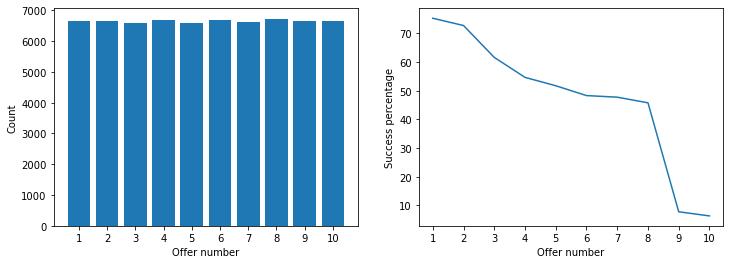

In [47]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)

ax[0].bar(success_percentage.index + 1, success_percentage['count'])
ax[0].set_xticks(np.arange(0,10) + 1)
ax[0].set_xlabel('Offer number')
ax[0].set_ylabel('Count')

ax[1].plot(success_percentage.index + 1, success_percentage['success_percentage'])
ax[1].set_xticks(np.arange(0,10) + 1)
ax[1].set_xlabel('Offer number')
ax[1].set_ylabel('Success percentage')

## Build models

### Create train and test data sets 

In [48]:
# factors/features that influence the label variable
features = data.drop(columns=['offer_successful'])
label = data.filter(['offer_successful'])

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features.values, label.values, test_size=0.3, random_state=42)

# extract offer_id, total_amount and convert other features to float of train data
offer_id_train = X_train[:, 0]
total_amount_train = X_train[:, 1]
X_train = X_train[:, 2:].astype('float64')

# extract offer_id, total_amount and convert other features to float of test data
offer_id_test = X_test[:, 0]
total_amount_test = X_test[:, 1]
X_test = X_test[:, 2:].astype('float64')

# convert train and test labels to array
y_train = y_train.ravel()
y_test = y_test.ravel()

### Naive Predictor

In [49]:
naive_predictor_accuracy = accuracy_score(y_train, np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: %.3f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.3f" % (naive_predictor_f1score))

Naive predictor accuracy: 0.471
Naive predictor f1-score: 0.640


In [57]:
naive_predictor_accuracy = accuracy_score(y_test, np.ones(len(y_test)))
naive_predictor_f1score = f1_score(y_test, np.ones(len(y_test)))

print("Naive predictor accuracy: %.3f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.3f" % (naive_predictor_f1score))

Naive predictor accuracy: 0.474
Naive predictor f1-score: 0.643


### Logistic Regression

In [50]:
def evaluate_model_performance(clf, X_data, y_data):
    '''
    This function evalutes the model on the provided data
    Input:-  clf: trained model
             X_data: X part of the data
             Y_data: Y part of the data
    Output:- clf_accuracy: Accuracy of the model
             clf_f1_score: F1 score of the model
    '''
    
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_data)

    clf_accuracy = accuracy_score(y_data, y_pred_rf)
    clf_f1_score = f1_score(y_data, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

In [51]:
scorer_ = make_scorer(fbeta_score, beta=0.5)

# instantiate a logistic regression classifer object
lr_clf_ = LogisticRegression(random_state=42, solver='liblinear')

# parameters dict for tunning the model
grid_params_ = {
    'penalty': ['l1', 'l2'],
    'C': [1.0, 0.1, 0.01]}

lr_random_ = RandomizedSearchCV(
    estimator = lr_clf_, param_distributions = grid_params_, 
    scoring=scorer_, n_iter = 6, cv = 3, verbose=2, 
    random_state=42, n_jobs = 3)

# fitting the train data to the model
lr_random_.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\dhand\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(random_state=42,
                                                solver='liblinear'),
                   n_iter=6, n_jobs=3,
                   param_distributions={'C': [1.0, 0.1, 0.01],
                                        'penalty': ['l1', 'l2']},
                   random_state=42, scoring=make_scorer(fbeta_score, beta=0.5),
                   verbose=2)

In [52]:
# evaluate logistic regression model's performance
evaluate_model_performance(lr_random_.best_estimator_, X_train, y_train)

LogisticRegression model accuracy: 0.698
LogisticRegression model f1-score: 0.694


(0.6980021482277121, 0.6935118165169616)

#### Results
- The accuracy and f1-score of a logistic regression model are higher than that of a naive predictor, according to the findings
- Accuracy
    - Naive predictor: 0.471
    - Logistic regression: 0.697
- F1-score
    - Naive predictor: 0.640
    - Logistic regression: 0.693

### Evaluate Test Data Performance

In [54]:
evaluate_model_performance(lr_random_, X_test, y_test)

RandomizedSearchCV model accuracy: 0.702
RandomizedSearchCV model f1-score: 0.698


(0.7018695804721568, 0.6977335095029984)

### Construct Random Forest Classifier Model

In [56]:
# instantiate a random forest classifier obj
rf_clf_ = RandomForestClassifier(random_state=42)

# Random forest classifier parameters
n_estimators = [10, 50, 100, 150, 200, 250, 300, 350]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.arange(3, 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# Create the random forest dictionary
grid_params_ = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# tuning the classifer
rf_random_ = RandomizedSearchCV(estimator = rf_clf_,
                               param_distributions = grid_params_,
                               scoring=scorer_,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = 3)

# fitting of train data to the classifier
rf_random_.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=3,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 150, 200,
                                                         250, 300, 350]},
                   random_state=42, scoring=make_scorer(fbeta_score, beta=0.5),
                   verbose=2)

In [58]:
# evaluate random forest classifier model's performance
evaluate_model_performance(rf_random_.best_estimator_, X_train, y_train)

RandomForestClassifier model accuracy: 0.760
RandomForestClassifier model f1-score: 0.751


(0.7604296455424275, 0.751082540957993)

#### Results
- Results suggest that a random forest model's accuracy and f1-score is better than the naive predictor
- Accuracy
    - Naive predictor: 0.471
    - Random forest: 0.762
- F1-score
    - Naive predictor: 0.640
    - Random forest: 0.753

### Evaluate Test Data Performance

In [59]:
evaluate_model_performance(rf_random_.best_estimator_, X_test, y_test)

RandomForestClassifier model accuracy: 0.739
RandomForestClassifier model f1-score: 0.729


(0.7386095935040851, 0.7294703532707373)

NOTE: There are a few things to keep in mind when building these models: all features were converted to numericals in order to fit and train the models above. A machine learning model's bias and variance are two features. Inherent model assumptions about the decision border between distinct classes are referred to as bias. Variance, on the other hand, relates to the sensitivity of a model to changes in its inputs. Because these factors might sometimes influence our outcomes, models must be thoroughly verified for bias and variance. In addition, we must ensure that data does not overfit the model while partitioning train and test datasets and modifying parameters to fit a model.

## Conclusion

I selected to solve the problem of developing a model that predicts whether a customer will respond to an offer. My approach to solve this problem consists mostly of two steps. I started by combining data from the offer portfolio, client profile, and transaction data. Second, I evaluated the precision and F1-score of a naive model that assumes all offers are accepted. Third, I compared how well logistic regression and random forest models performed. A random forest model has the best training data accuracy and F1-score, according to this investigation. The random forest model has a training data accuracy of 0.762 and an F1-score of 0.753, according to the analysis. The accuracy of the test data set was 0.740, and the F1-score was 0.730.

However, by analysing features that effect an offer's success rate as a function of offer complexity, duration, and incentive, the performance of a random forest model can still be improved. These extra features should allow a random forest classifier to build a better decision boundary that distinguishes between successful and unsuccessful customer offers.

Also, it appeared that we had a lot of data to work with at first, but once NaN values and duplicate columns were removed and the data was consolidated into a single dataset, it appeared that the models could have benefited from more data. The classification models may have been able to deliver greater accuracy and F1-score outcomes if they had additional data.

Furthermore, if there were additional consumer measurements, better predictions may have been made. I believe we had little information on our customers for this analysis - only their age, gender, and income. It would be excellent to add a few more customer features to determine the best consumer demographics. These extra features could help improve the categorization model's findings.